# Permutation Importance on Model M042
- Per Type, find features which do not help the model

In [1]:
import pandas as pd
import catboost
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import numpy as np
import gc

In [2]:
fi = pd.read_csv('../temp/M043/temp3of8_M043_0710_1505_fi_catboost_2folds_500000iter_0.1lr.csv')

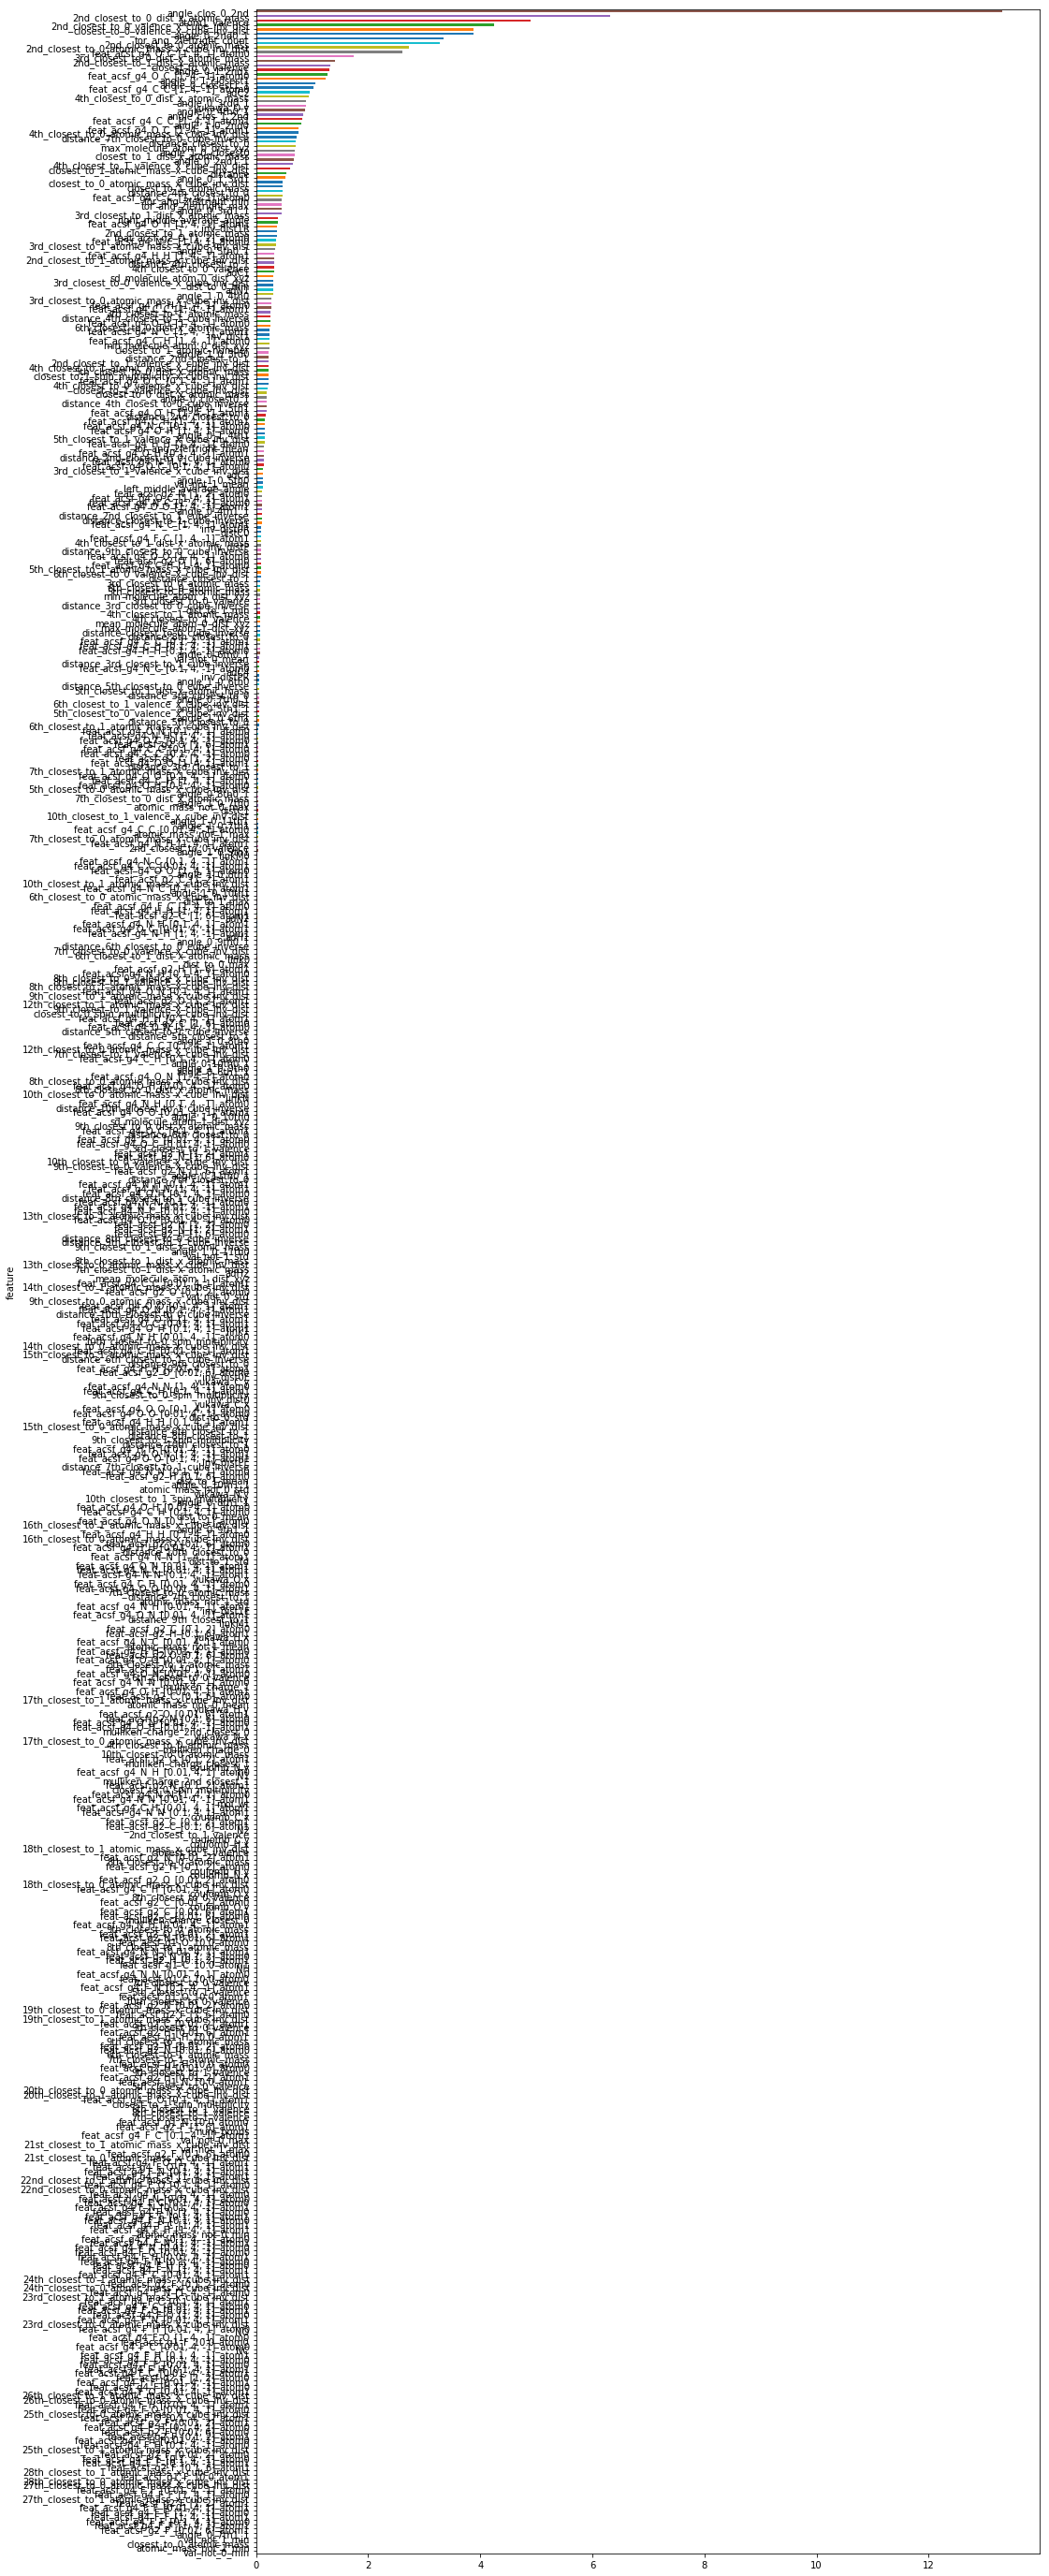

In [25]:
t = '2JHC'
fi.loc[fi['type'] == t].groupby('feature').mean().sort_values('importance')['importance'].plot(kind='barh', figsize=(15, 50))

In [15]:
def permutation_importance(model, X_val, y_val, metric, t, threshold=0.005,
                           minimize=True, verbose=True, thread_count=16):
    """
    Reference: https://www.kaggle.com/speedwagon/permutation-importance
    
    Modified by Rob
    """
    results = {}
    
    y_pred = model.predict(X_val, thread_count=thread_count)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')

    temp = fi.loc[fi['type'] == '2JHC'].groupby('feature').mean().sort_values('importance')
    feature_list = temp.loc[temp['importance'] > 0.001].index.tolist()    
    
    for col in tqdm(feature_list):
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        preds = model.predict(X_val, thread_count=thread_count)
        results[col] = metric(y_val, preds)
        if results[col] > results['base_score'] + threshold:
            print('Stopping because first feature has reached the threshold')
            break
        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] + threshold]
    bad_features.remove('base_score')
    
    return results, bad_features

In [ ]:
types = ['2JHC']
MODEL_NUMBER = 'M043'
RUN_ID = '0710_1505'
FE_NUMBER = 'FE018'
results_dict = {}
bad_features_dict = {}
for t in types:
    print(f'Running for {t}')
    train = pd.read_parquet(f'../data/{FE_NUMBER}/{FE_NUMBER}-train-{t}.parquet')
    x = pd.read_parquet('../data/FE008_train.parquet') # only loading for skeleton not features
    model = catboost.CatBoostRegressor()
    model.load_model(f'../models/{MODEL_NUMBER}/{MODEL_NUMBER}-{RUN_ID}-{t}-1.model')
    print('Model loaded')
    mol_group = x[['molecule_name','type']].copy()
    N_FOLDS = 2
    folds = GroupKFold(n_splits=N_FOLDS)
    X = train[model.feature_names_]
    y = train['scalar_coupling_constant']
    del train
    gc.collect()
    mol_group_type = mol_group.loc[mol_group['type'] == t]['molecule_name']
    for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X, groups=mol_group_type)):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        X_valid = X_valid.copy()
        results, bad_features = permutation_importance(model, X_valid, y_valid, metric=mean_absolute_error, t=t)
        results_dict[t] = results
        bad_features_dict[t] = bad_features
        break # Only run for the first fold
    print(f'Bad features for {t}:')
    print(bad_features)
    del x, X, y, mol_group_type
    gc.collect()

Running for 2JHC
Model loaded



  0%|          | 0/450 [00:00<?, ?it/s]

Base score 0.21313



  0%|          | 1/450 [01:29<11:10:55, 89.66s/it]

column: 9th_closest_to_0_valence - 0.21327



  0%|          | 2/450 [02:59<11:10:03, 89.74s/it]

column: feat_acsf_g2_C_[0.01, 2]_atom1 - 0.21335



  1%|          | 3/450 [04:28<11:06:46, 89.50s/it]

column: 19th_closest_to_1_atomic_mass_x_cube_inv_dist - 0.21328



  1%|          | 4/450 [06:02<11:16:02, 90.95s/it]

column: feat_acsf_g2_F_[1, 6]_atom0 - 0.21327



  1%|          | 5/450 [07:34<11:16:52, 91.26s/it]

column: 19th_closest_to_0_atomic_mass_x_cube_inv_dist - 0.21326
